In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings(action='ignore')

# Infrastructure

In [2]:
class PriceVolPredict:
    def __init__(self, path='./price_vol_filledNa.csv'):
        self.df = pd.read_csv(path, index_col=0)
    
    @staticmethod
    def ColSelector(df: pd.DataFrame, series=None, toker_list=None):
        cols = df.columns
        res = []
        if series and toker_list:
            res = [x for x in cols if x.split('-')[0] in toker_list and x.split('-')[1] in series]
        elif series:
            res = [x for x in cols if x.split('-')[1] in series]
        elif toker_list:
            res = [x for x in cols if x.split('-')[0] in toker_list]
        return res    
    
    def train_test(self, test_size=0.1):
        # X = self.df.drop(columns=['BTC-close', 'BTC-open', 'BTC-high', 'BTC-low']).shift(1).iloc[1:, :]
        X = self.df.shift(1).iloc[1:, :]
        Y = (self.df[['BTC-close']].iloc[1:, :] > 0)
        return train_test_split(X, Y, test_size = 0.1, shuffle=False)
    
    @staticmethod
    def backtest(real_return, signal):
        """
        This is a basic version of backtesting, where signal 1 represents buy/hold whereas 
        signal 0 represents sell/emtpy. The starting amount is 1. 
        """
        strategy = (signal * (1 + real_return)).cumprod()
        benchmark = (1 + real_return).cumprod()
        return pd.DataFrame({"benchmark": benchmark, "strategy": strategy}).plot()

In [3]:
class Pipelines:
    def __init__(self, *args):
        self.pipe = Pipeline(args)
        self.hyperparameter = dict()
        
    def timeseries_cv(self, X_train, Y_train, n_fold=5):
        cv = TimeSeriesSplit(n_splits=n_fold)
        return cross_val_score(self.pipe, X_train, Y_train, cv=cv, verbose=False)
    
    def fit_train(self, X_train, Y_train):
        self.pipe.fit(X_train, Y_train)
        return self.pipe.predict(X_train)
    
    def predict_test(self, X_test):
        return self.pipe.predict(X_test)
    
    def hyperparameter_tuning(self):
        pass    

In [4]:
p_v = PriceVolPredict()
X_train_all, X_test, Y_train_all, Y_test = p_v.train_test()
X_train_all.shape, X_test.shape, Y_train_all.shape, Y_test.shape

((15750, 250), (1750, 250), (15750, 1), (1750, 1))

# Logistic Regression

In [5]:
model = [('std_scaler', StandardScaler()), ('logistic', LogisticRegression())]
pipe = Pipelines(*model)
cv_score = pipe.timeseries_cv(X_train_all, Y_train_all)
f"Cross validation score: {(sum(cv_score) / len(cv_score)).round(4)}"

'Cross validation score: 0.5029'

In [6]:
pipe.fit_train(X_train_all, Y_train_all)
Y_hat = pipe.predict_test(X_test)
f"Accuracy in test set: {accuracy_score(Y_test, Y_hat).round(4)}"

'Accuracy in test set: 0.5034'

<AxesSubplot:>

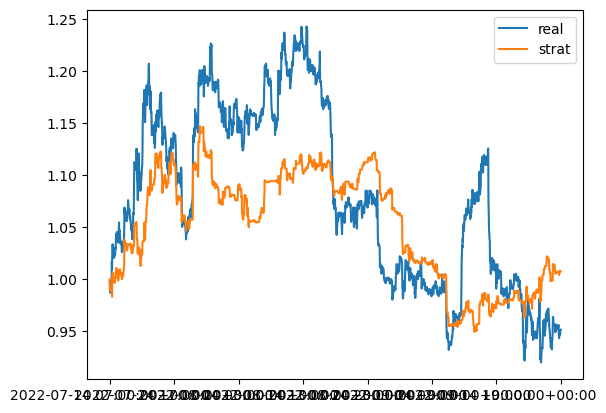

In [7]:
result_logistic = Y_test.copy(deep=True)
result_logistic = pd.merge(result_logistic, p_v.df[['BTC-close']], how='left', left_index=True, right_index=True)
result_logistic['signal'] = Y_hat.astype(int)
result_logistic['real'] = (1 + result_logistic['BTC-close_y']).cumprod()
result_logistic['strat'] = (1 + result_logistic['BTC-close_y'] * 
                            result_logistic['signal']).cumprod()
result_logistic[['real', 'strat']].plot()

# SVM

In [8]:
model = [('std_scaler', StandardScaler()), ('svm', svm.SVC())]
pipe = Pipelines(*model)
cv_score = pipe.timeseries_cv(X_train_all, Y_train_all)
f"Cross validation score: {(sum(cv_score) / len(cv_score)).round(4)}"

'Cross validation score: 0.5019'

In [9]:
pipe.fit_train(X_train_all, Y_train_all)
Y_hat = pipe.predict_test(X_test)
f"Accuracy in test set: {accuracy_score(Y_test, Y_hat).round(4)}"

'Accuracy in test set: 0.5126'

<AxesSubplot:>

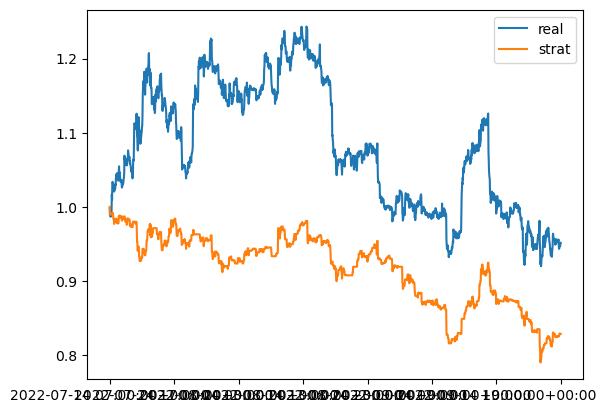

In [10]:
result_logistic = Y_test.copy(deep=True)
result_logistic = pd.merge(result_logistic, p_v.df[['BTC-close']], how='left', left_index=True, right_index=True)
result_logistic['signal'] = Y_hat.astype(int)
result_logistic['real'] = (1 + result_logistic['BTC-close_y']).cumprod()
result_logistic['strat'] = (1 + result_logistic['BTC-close_y'] * 
                            result_logistic['signal']).cumprod()
result_logistic[['real', 'strat']].plot()

# Decision Tree

In [11]:
model = [('std_scaler', StandardScaler()), ('decision_tree', tree.DecisionTreeClassifier())]
pipe = Pipelines(*model)
cv_score = pipe.timeseries_cv(X_train_all, Y_train_all)
f"Cross validation score: {(sum(cv_score) / len(cv_score)).round(4)}"

'Cross validation score: 0.5022'

In [12]:
pipe.fit_train(X_train_all, Y_train_all)
Y_hat = pipe.predict_test(X_test)
f"Accuracy in test set: {accuracy_score(Y_test, Y_hat).round(4)}"

'Accuracy in test set: 0.4771'

<AxesSubplot:>

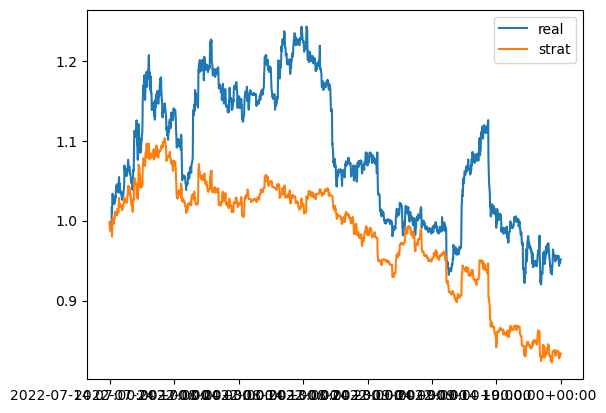

In [13]:
result_logistic = Y_test.copy(deep=True)
result_logistic = pd.merge(result_logistic, p_v.df[['BTC-close']], how='left', left_index=True, right_index=True)
result_logistic['signal'] = Y_hat.astype(int)
result_logistic['real'] = (1 + result_logistic['BTC-close_y']).cumprod()
result_logistic['strat'] = (1 + result_logistic['BTC-close_y'] * 
                            result_logistic['signal']).cumprod()
result_logistic[['real', 'strat']].plot()

# Random Forest

In [14]:
model = [('std_scaler', StandardScaler()), ('rf', RandomForestClassifier(n_estimators=10))]
pipe = Pipelines(*model)
cv_score = pipe.timeseries_cv(X_train_all, Y_train_all)
f"Cross validation score: {(sum(cv_score) / len(cv_score)).round(4)}"

'Cross validation score: 0.5112'

In [15]:
pipe.fit_train(X_train_all, Y_train_all)
Y_hat = pipe.predict_test(X_test)
f"Accuracy in test set: {accuracy_score(Y_test, Y_hat).round(4)}"

'Accuracy in test set: 0.5177'

<AxesSubplot:>

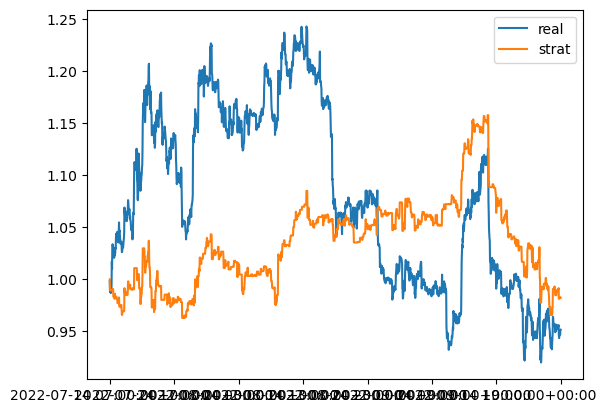

In [16]:
result_logistic = Y_test.copy(deep=True)
result_logistic = pd.merge(result_logistic, p_v.df[['BTC-close']], how='left', left_index=True, right_index=True)
result_logistic['signal'] = Y_hat.astype(int)
result_logistic['real'] = (1 + result_logistic['BTC-close_y']).cumprod()
result_logistic['strat'] = (1 + result_logistic['BTC-close_y'] * 
                            result_logistic['signal']).cumprod()
result_logistic[['real', 'strat']].plot()